In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
final = pd.read_csv('final_dataset.csv')
final.head()

,HCHO readings,Location,Current date,Next Date
0,0.000197,Colombo Proper,2019-01-01,2019-01-02
1,0.000263,Colombo Proper,2019-01-02,2019-01-03
2,0.000099,Colombo Proper,2019-01-03,2019-01-04
3,0.000210,Colombo Proper,2019-01-04,2019-01-05
4,0.000179,Colombo Proper,2019-01-05,2019-01-06


In [3]:
city_dfs = {}

# Iterate over unique cities
cities = ['Colombo Proper', 'Deniyaya, Matara', 'Nuwara Eliya Proper', 'Bibile, Monaragala', 'Kurunegala Proper', 'Jaffna Proper', 'Kandy Proper']
for city in cities:
    city_dfs[city] = final[final['Location'] == city]

# Write each city's DataFrame to a CSV file
for city, city_df in city_dfs.items():
    city_df.to_csv(f"City Datasets/{city}.csv", index=False)

### Training for Colombo

In [4]:
# Import dataset
cmb = pd.read_csv('City Datasets/Colombo Proper.csv')
cmb.head()

,HCHO readings,Location,Current date,Next Date
0,0.000197,Colombo Proper,2019-01-01,2019-01-02
1,0.000263,Colombo Proper,2019-01-02,2019-01-03
2,0.000099,Colombo Proper,2019-01-03,2019-01-04
3,0.000210,Colombo Proper,2019-01-04,2019-01-05
4,0.000179,Colombo Proper,2019-01-05,2019-01-06


In [5]:
dropped_columns = ['Location','Next Date']

cmb_dataset = cmb.drop(columns = dropped_columns)
cmb_dataset = cmb_dataset.reset_index(drop = True)
cmb_dataset.head()

,HCHO readings,Current date
0,0.000197,2019-01-01
1,0.000263,2019-01-02
2,0.000099,2019-01-03
3,0.000210,2019-01-04
4,0.000179,2019-01-05


In [6]:
cmb['Current date'] = pd.to_datetime(cmb['Current date'])

In [7]:
cmb.isnull().sum()

HCHO readings    0
Location         0
Current date     0
Next Date        0
dtype: int64

In [8]:
cmb_split = int(len(cmb) * 0.8)
cmb_train, cmb_test = cmb.iloc[:cmb_split],cmb.iloc[cmb_split:]

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-23731.864, Time=4.35 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-22977.302, Time=0.51 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-23395.958, Time=0.58 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-23712.778, Time=9.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-22979.251, Time=0.36 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-23733.832, Time=10.92 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-23736.138, Time=4.24 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-23735.267, Time=6.23 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=-23742.850, Time=4.88 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=-23742.022, Time=6.71 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=-23740.538, Time=5.54 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=-23738.563, Time=5.50 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=-23743.773, Time=0.70 sec
 ARIMA(0,1,2)(1,0,0)[12] intercept   : AIC=-23742.897, Time

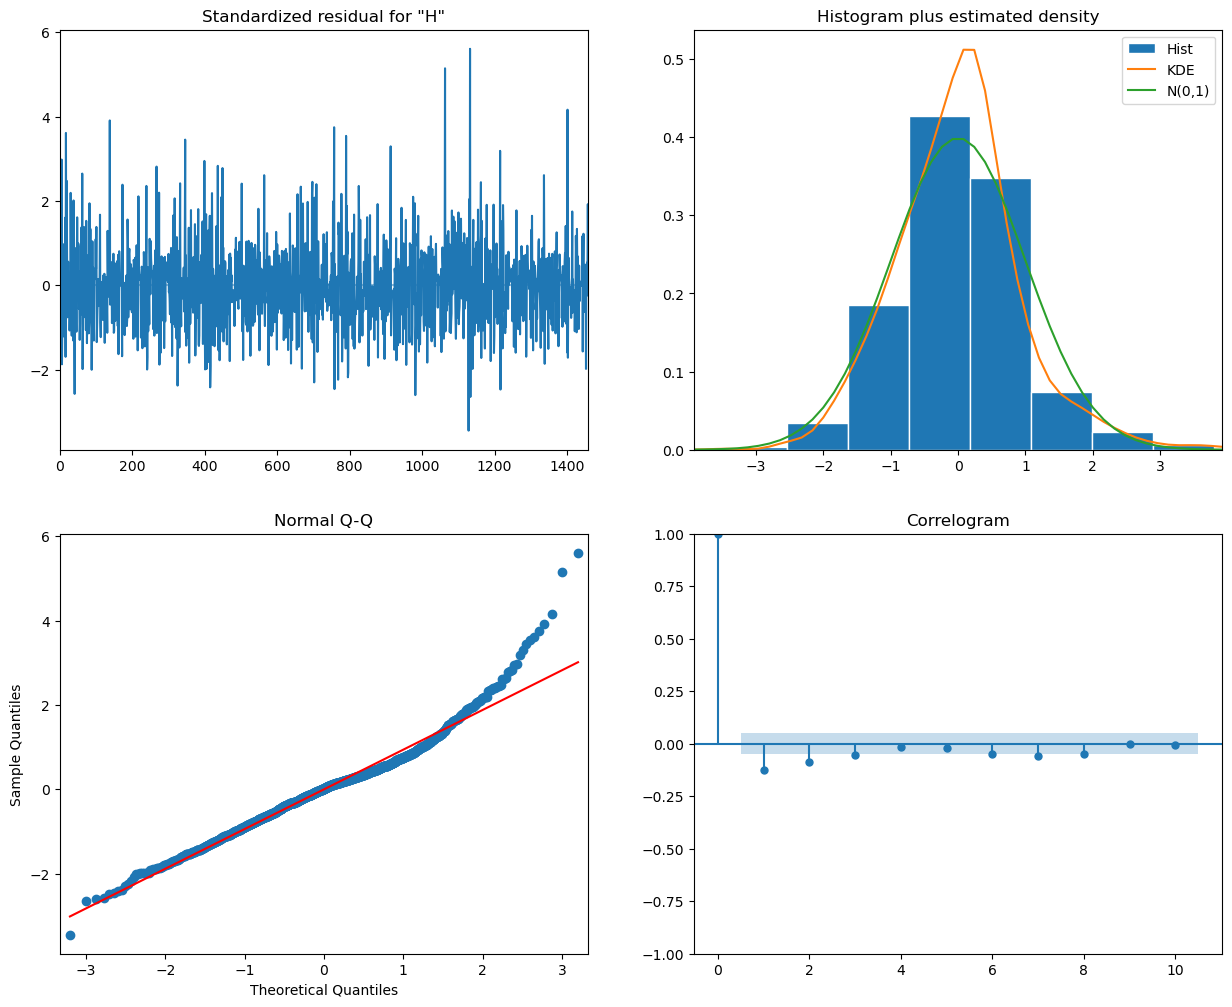

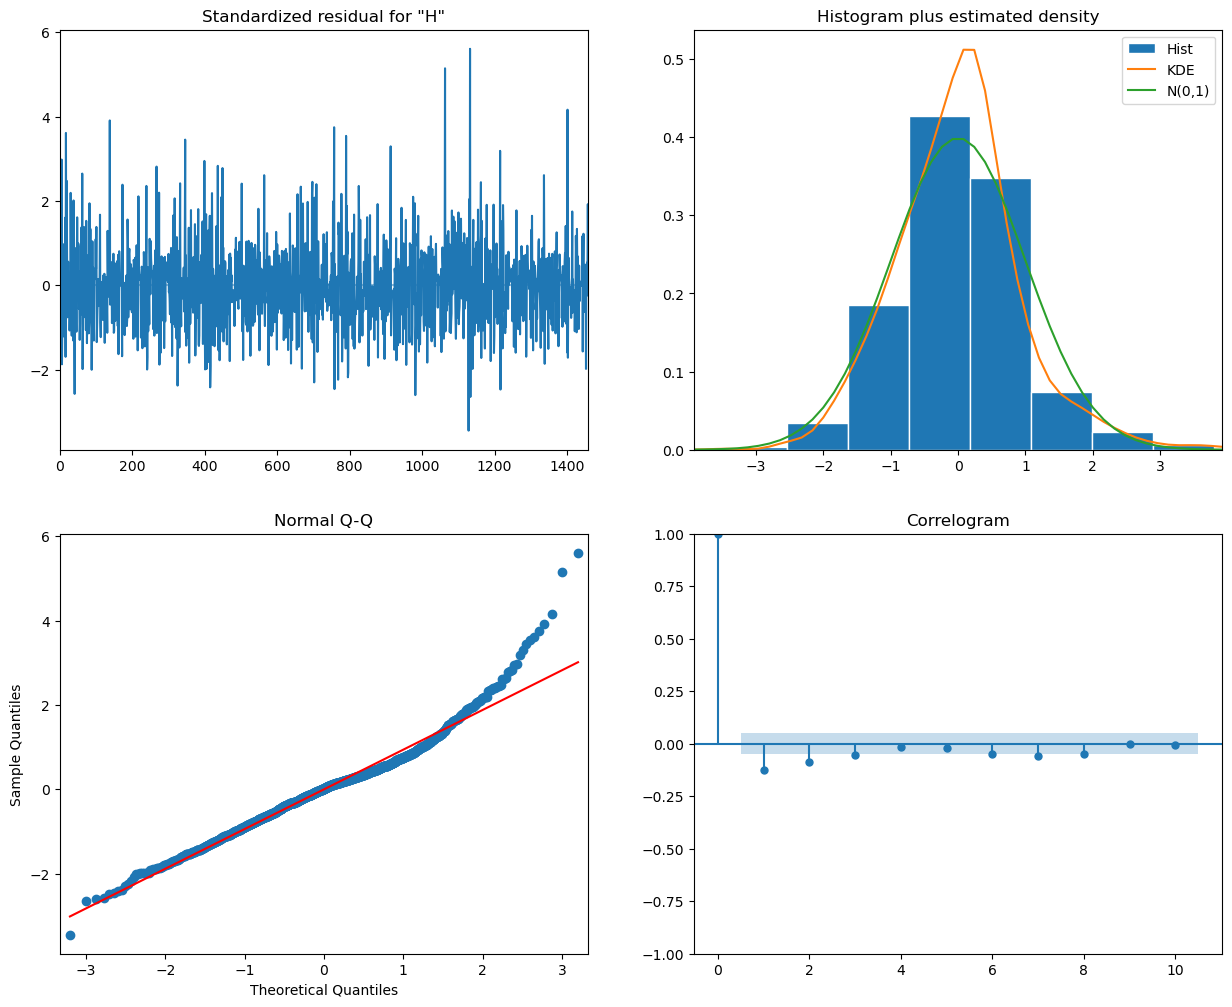

In [9]:
cmb_model = auto_arima(cmb_train['HCHO readings'], seasonal = True, trace = True, m = 12)
p,d,q = cmb_model.order
print(p,d,q)
cmb_arima = ARIMA(cmb_train['HCHO readings'], order=(p,d,q))
cmb_arima_fit = cmb_arima.fit()
print(cmb_arima_fit.summary())
cmb_arima_fit.plot_diagnostics(figsize=(15,12))

In [10]:
cmb_preds = cmb_arima_fit.forecast(steps = len(cmb_test))
cmb_mse = mean_squared_error(cmb_test['HCHO readings'], cmb_preds)
cmb_rmse = np.sqrt(mean_squared_error(cmb_test['HCHO readings'], cmb_preds))
cmb_r2 = r2_score(cmb_test['HCHO readings'], cmb_preds)

print(f'ARIMA RMSE for Colombo: {cmb_mse}')
print(f'R-squared value for Colombo: {cmb_rmse}')
print(f'ARIMA MSE for Colombo: {cmb_r2}\n')
print(cmb_preds)

ARIMA RMSE for Colombo: 6.71551172381397e-09
R-squared value for Colombo: 8.194822587349875e-05
ARIMA MSE for Colombo: -0.16347663909696397

1460    0.000206
1461    0.000203
1462    0.000197
1463    0.000196
1464    0.000196
          ...   
1821    0.000196
1822    0.000196
1823    0.000196
1824    0.000196
1825    0.000196
Name: predicted_mean, Length: 366, dtype: float64


In [11]:
forecast_range = 30
forecast_idx = pd.date_range(start = cmb['Current date'].max(), periods = forecast_range+1, freq = 'D')[1:]
forecast_HCHO = cmb_arima_fit.forecast(steps = forecast_range)
cmb_forecast = pd.DataFrame({'Current date': forecast_idx, 'HCHO_value': forecast_HCHO, 'Location':'Colombo'})
cmb_forecast.head()

,Current date,HCHO_value,Location
1460,2024-01-01,0.000206,Colombo
1461,2024-01-02,0.000203,Colombo
1462,2024-01-03,0.000197,Colombo
1463,2024-01-04,0.000196,Colombo
1464,2024-01-05,0.000196,Colombo


In [12]:
cmb_forecast.to_csv('Forecast Data/colombo_forecast.csv')

### Training for Monaragala

In [13]:
monaragala = pd.read_csv('City Datasets/Bibile, Monaragala.csv')
monaragala.head()

,HCHO readings,Location,Current date,Next Date
0,0.000126,"Bibile, Monaragala",2019-01-01,2019-01-02
1,0.000019,"Bibile, Monaragala",2019-01-02,2019-01-03
2,0.000028,"Bibile, Monaragala",2019-01-03,2019-01-04
3,0.000037,"Bibile, Monaragala",2019-01-04,2019-01-05
4,0.000135,"Bibile, Monaragala",2019-01-05,2019-01-06


In [14]:
dropped_columns = ['Location','Next Date']

mnr_dataset = monaragala.drop(columns = dropped_columns)
mnr_dataset = mnr_dataset.reset_index(drop = True)
mnr_dataset.head()

,HCHO readings,Current date
0,0.000126,2019-01-01
1,0.000019,2019-01-02
2,0.000028,2019-01-03
3,0.000037,2019-01-04
4,0.000135,2019-01-05


In [15]:
monaragala['Current date'] = pd.to_datetime(monaragala['Current date'])

In [16]:
monaragala.isnull().sum()

HCHO readings    0
Location         0
Current date     0
Next Date        0
dtype: int64

In [17]:
mnr_split = int(len(monaragala) * 0.8)
mnr_train, mnr_test = monaragala.iloc[:mnr_split],monaragala.iloc[mnr_split:]

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=6.32 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-24140.688, Time=0.42 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-23417.908, Time=2.92 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-24151.811, Time=2.62 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-21609.199, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-24152.667, Time=1.33 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=-23409.747, Time=2.26 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=5.68 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-24165.339, Time=1.68 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=-23411.245, Time=3.39 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-24163.900, Time=3.20 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=10.29 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=-24165.035, Time=0.90 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=-24170.712, Time=2.19 sec
 ARIMA(2,0,

C:\Users\wickn\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:          HCHO readings   No. Observations:                 1460
Model:                 ARIMA(2, 0, 0)   Log Likelihood               12091.173
Date:                Sun, 21 Apr 2024   AIC                         -24174.345
Time:                        15:39:11   BIC                         -24153.200
Sample:                             0   HQIC                        -24166.457
                               - 1460                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001   2.38e-06     56.413      0.000       0.000       0.000
ar.L1          0.1219   1.29e-11   9.44e+09      0.000       0.122       0.122
ar.L2          0.0878    1.7e-11   5.17e+09      0.0

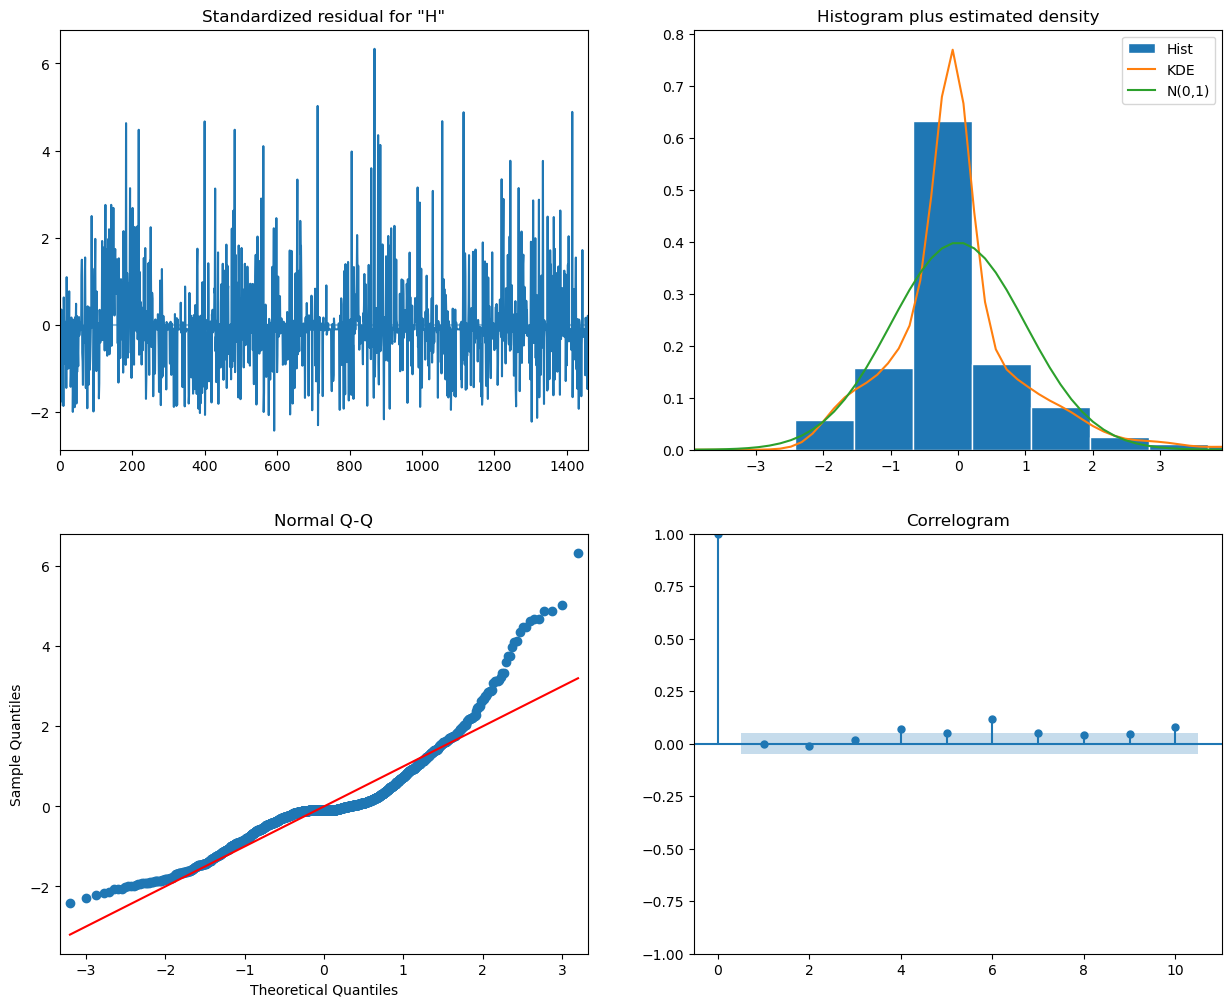

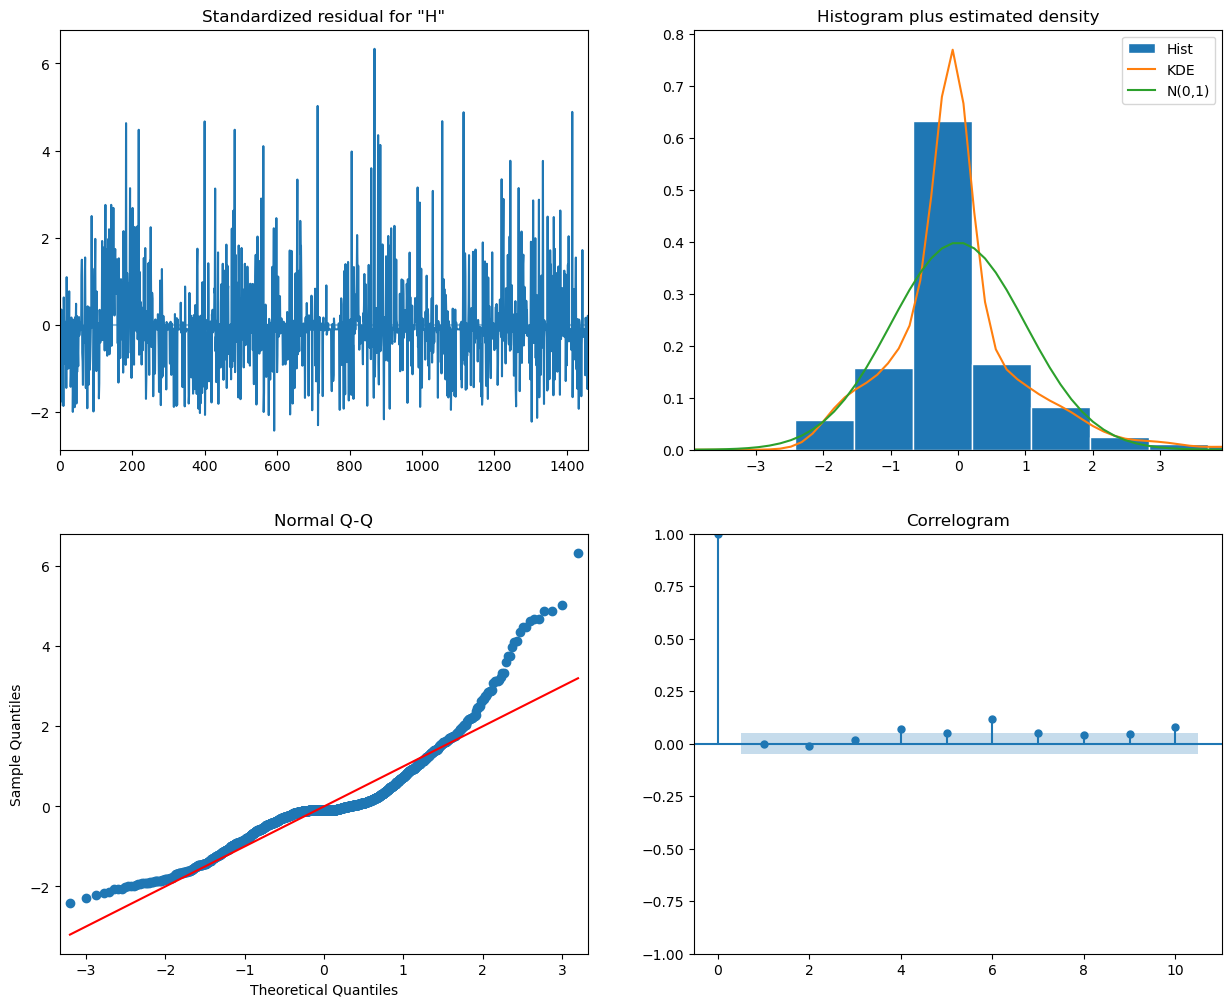

In [18]:
mnr_model = auto_arima(mnr_train['HCHO readings'], seasonal = True, trace = True, m = 12)
p,d,q = mnr_model.order
print(p,d,q)
mnr_arima = ARIMA(mnr_train['HCHO readings'], order=(p,d,q))
mnr_arima_fit = mnr_arima.fit()
print(mnr_arima_fit.summary())
mnr_arima_fit.plot_diagnostics(figsize=(15,12))

In [19]:
mnr_preds = mnr_arima_fit.forecast(steps = len(mnr_test))
mnr_mse = mean_squared_error(mnr_test['HCHO readings'], mnr_preds)
mnr_rmse = np.sqrt(mean_squared_error(mnr_test['HCHO readings'], mnr_preds))
mnr_r2 = r2_score(mnr_test['HCHO readings'], mnr_preds)

print(f'ARIMA RMSE for Monaragala: {mnr_mse}')
print(f'R-squared value for Monaragala: {mnr_rmse}')
print(f'ARIMA MSE for Monaragala: {mnr_r2}\n')
print(mnr_preds)

ARIMA RMSE for Monaragala: 3.5144988053488475e-09
R-squared value for Monaragala: 5.928320846031233e-05
ARIMA MSE for Monaragala: -0.003510582027372422

1460    0.000129
1461    0.000130
1462    0.000133
1463    0.000134
1464    0.000134
          ...   
1821    0.000134
1822    0.000134
1823    0.000134
1824    0.000134
1825    0.000134
Name: predicted_mean, Length: 366, dtype: float64


In [20]:
forecast_range = 30
forecast_idx = pd.date_range(start = monaragala['Current date'].max(), periods = forecast_range+1, freq = 'D')[1:]
forecast_HCHO = mnr_arima_fit.forecast(steps = forecast_range)
mnr_forecast = pd.DataFrame({'Current date': forecast_idx, 'HCHO_value': forecast_HCHO, 'Location':'Monaragala'})
mnr_forecast.head()

,Current date,HCHO_value,Location
1460,2024-01-01,0.000129,Monaragala
1461,2024-01-02,0.000130,Monaragala
1462,2024-01-03,0.000133,Monaragala
1463,2024-01-04,0.000134,Monaragala
1464,2024-01-05,0.000134,Monaragala


In [21]:
mnr_forecast.to_csv('Forecast Data/monaragala_forecast.csv')

### Training for Nuwara Eliya

In [22]:
# Import dataset
nuwaraEliya = pd.read_csv('City Datasets/Nuwara Eliya Proper.csv')
nuwaraEliya.head()

,HCHO readings,Location,Current date,Next Date
0,0.000088,Nuwara Eliya Proper,2019-01-01,2019-01-02
1,0.000088,Nuwara Eliya Proper,2019-01-02,2019-01-03
2,0.000191,Nuwara Eliya Proper,2019-01-03,2019-01-04
3,0.000051,Nuwara Eliya Proper,2019-01-04,2019-01-05
4,0.000065,Nuwara Eliya Proper,2019-01-05,2019-01-06


In [23]:
dropped_columns = ['Location','Next Date']

nwr_dataset = nuwaraEliya.drop(columns = dropped_columns)
nwr_dataset = nwr_dataset.reset_index(drop = True)
nwr_dataset.head()

,HCHO readings,Current date
0,0.000088,2019-01-01
1,0.000088,2019-01-02
2,0.000191,2019-01-03
3,0.000051,2019-01-04
4,0.000065,2019-01-05


In [24]:
nuwaraEliya ['Current date'] = pd.to_datetime(nuwaraEliya ['Current date'])

In [25]:
nuwaraEliya.isnull().sum()

HCHO readings    0
Location         0
Current date     0
Next Date        0
dtype: int64

In [26]:
nwr_split = int(len(nuwaraEliya) * 0.8)
nwr_train, nwr_test = nuwaraEliya.iloc[:nwr_split],nuwaraEliya.iloc[nwr_split:]

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-25063.468, Time=2.03 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-24292.906, Time=0.39 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-24589.913, Time=2.67 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-24904.093, Time=6.78 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-24295.196, Time=0.41 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-25065.516, Time=1.71 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-25067.199, Time=1.03 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-25065.246, Time=1.77 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=-25056.824, Time=17.54 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=-24940.829, Time=7.17 sec
 ARIMA(3,1,2)(0,0,0)[12] intercept   : AIC=-25086.914, Time=0.99 sec
 ARIMA(3,1,2)(1,0,0)[12] intercept   : AIC=-25086.007, Time=2.03 sec
 ARIMA(3,1,2)(0,0,1)[12] intercept   : AIC=-25085.998, Time=2.08 sec
 ARIMA(3,1,2)(1,0,1)[12] intercept   : AIC=-25083.951, Time

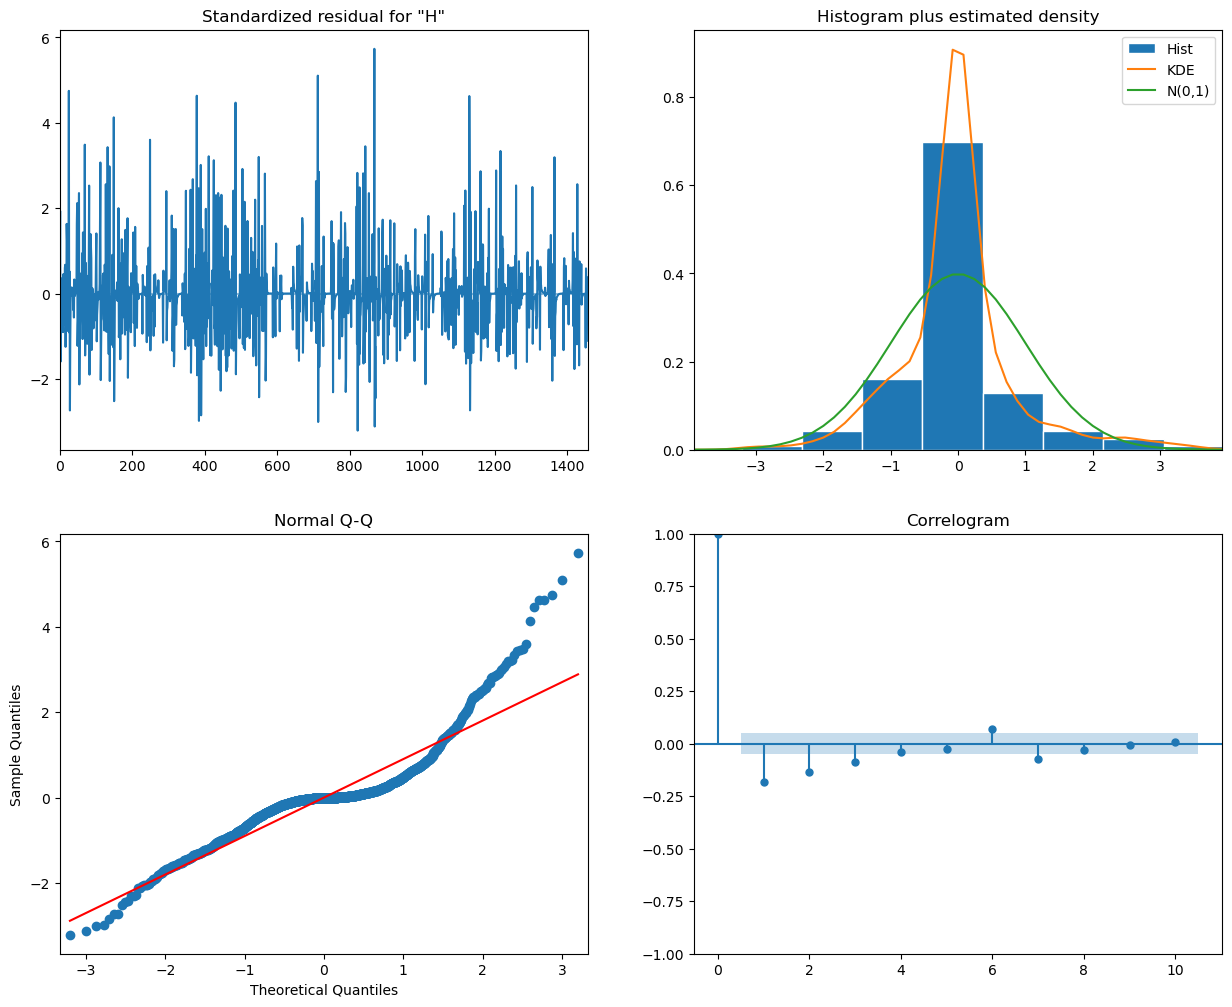

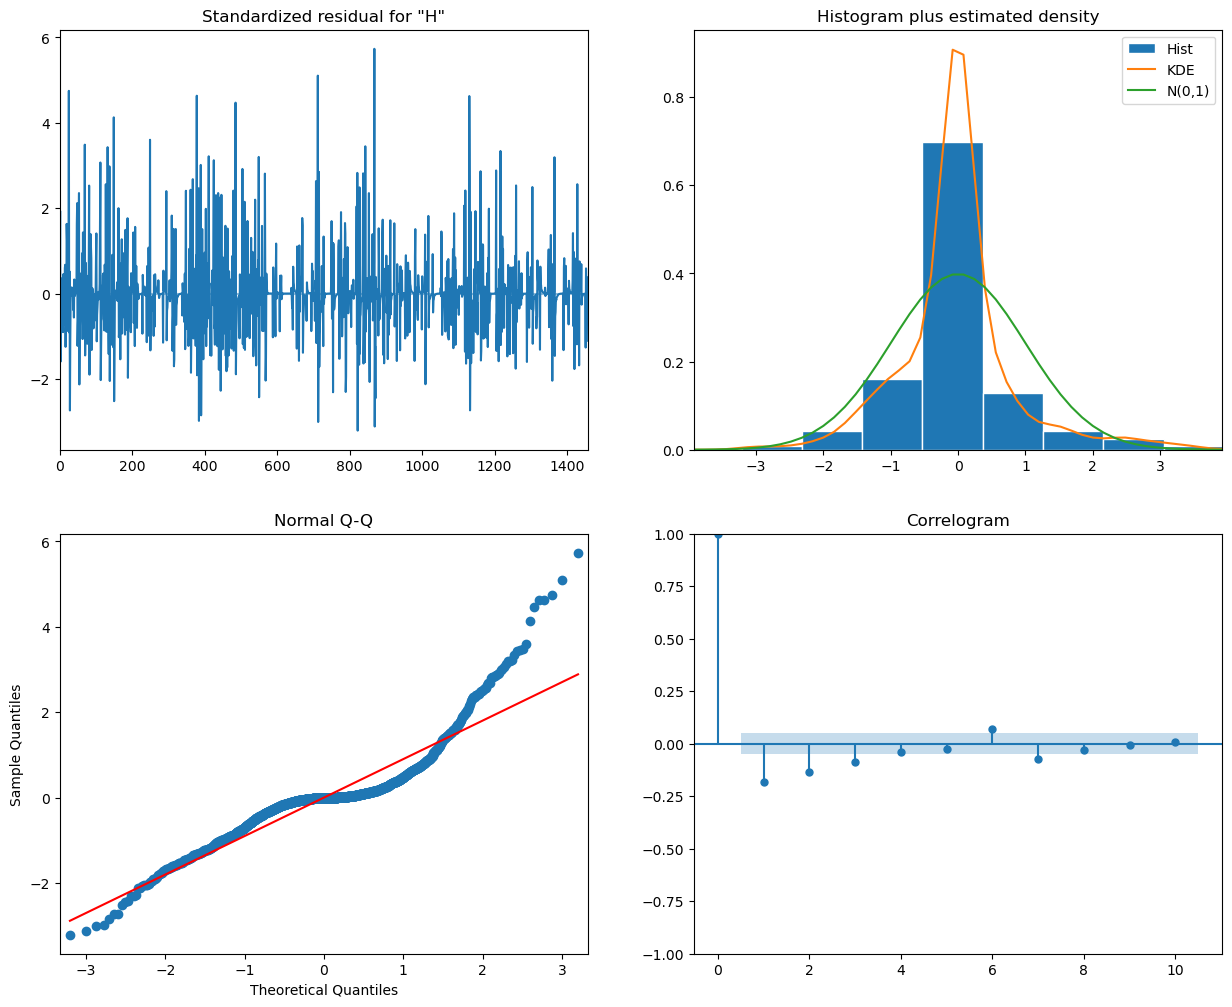

In [27]:
nwr_model = auto_arima(nwr_train['HCHO readings'], seasonal = True, trace = True, m = 12)
p,d,q = nwr_model.order
print(p,d,q)
nwr_arima = ARIMA(nwr_train['HCHO readings'], order=(p,d,q))
nwr_arima_fit = nwr_arima.fit()
print(nwr_arima_fit.summary())
nwr_arima_fit.plot_diagnostics(figsize=(15,12))

In [28]:
nwr_preds = nwr_arima_fit.forecast(steps = len(nwr_test))
nwr_mse = mean_squared_error(nwr_test['HCHO readings'], nwr_preds)
nwr_rmse = np.sqrt(mean_squared_error(nwr_test['HCHO readings'], nwr_preds))
nwr_r2 = r2_score(nwr_test['HCHO readings'], nwr_preds)

print(f'ARIMA RMSE for Nuwara Eliya: {nwr_mse}')
print(f'R-squared value for Nuwara Eliya: {nwr_rmse}')
print(f'ARIMA MSE for Nuwara Eliya: {nwr_r2}\n')
print(nwr_preds)

ARIMA RMSE for Nuwara Eliya: 2.31641399638e-09
R-squared value for Nuwara Eliya: 4.812913874546271e-05
ARIMA MSE for Nuwara Eliya: -0.5134168332231919

1460    0.000059
1461    0.000064
1462    0.000063
1463    0.000066
1464    0.000065
          ...   
1821    0.000066
1822    0.000066
1823    0.000066
1824    0.000066
1825    0.000066
Name: predicted_mean, Length: 366, dtype: float64


In [29]:
forecast_range = 30
forecast_idx = pd.date_range(start = nuwaraEliya['Current date'].max(), periods = forecast_range+1, freq = 'D')[1:]
forecast_HCHO = nwr_arima_fit.forecast(steps = forecast_range)
nwr_forecast = pd.DataFrame({'Current date': forecast_idx, 'HCHO_value': forecast_HCHO, 'Location':'Nuwara Eliya'})
nwr_forecast.head()

,Current date,HCHO_value,Location
1460,2024-01-01,0.000059,Nuwara Eliya
1461,2024-01-02,0.000064,Nuwara Eliya
1462,2024-01-03,0.000063,Nuwara Eliya
1463,2024-01-04,0.000066,Nuwara Eliya
1464,2024-01-05,0.000065,Nuwara Eliya


In [30]:
nwr_forecast.to_csv('Forecast Data/nuwaraEliya_forecast.csv')

### Training for Matara

In [31]:
# Import dataset
matara = pd.read_csv('City Datasets/Deniyaya, Matara.csv')
matara.head()

,HCHO readings,Location,Current date,Next Date
0,0.000092,"Deniyaya, Matara",2019-01-01,2019-01-02
1,0.000006,"Deniyaya, Matara",2019-01-02,2019-01-03
2,0.000236,"Deniyaya, Matara",2019-01-03,2019-01-04
3,0.000064,"Deniyaya, Matara",2019-01-04,2019-01-05
4,0.000053,"Deniyaya, Matara",2019-01-05,2019-01-06


In [32]:
dropped_columns = ['Location','Next Date']

mtr_dataset = matara.drop(columns = dropped_columns)
mtr_dataset = mtr_dataset.reset_index(drop = True)
mtr_dataset.head()

,HCHO readings,Current date
0,0.000092,2019-01-01
1,0.000006,2019-01-02
2,0.000236,2019-01-03
3,0.000064,2019-01-04
4,0.000053,2019-01-05


In [33]:
matara['Current date'] = pd.to_datetime(matara['Current date'])

In [34]:
matara.isnull().sum()

HCHO readings    0
Location         0
Current date     0
Next Date        0
dtype: int64

In [35]:
mtr_split = int(len(matara) * 0.8)
mtr_train, mtr_test = matara.iloc[:mtr_split],matara.iloc[mtr_split:]

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=8.21 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-24148.000, Time=0.32 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-23516.665, Time=2.35 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-24148.016, Time=1.03 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-22255.047, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-24152.631, Time=0.52 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=-23517.802, Time=1.20 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=3.76 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-24151.624, Time=0.62 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=-24149.915, Time=0.75 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=-24153.612, Time=1.19 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=-24148.869, Time=1.13 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=6.88 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=-24151.897, Time=0.75 sec
 ARIMA(2,0,1

C:\Users\wickn\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:          HCHO readings   No. Observations:                 1460
Model:                 ARIMA(1, 0, 0)   Log Likelihood               12079.806
Date:                Sun, 21 Apr 2024   AIC                         -24153.612
Time:                        15:41:06   BIC                         -24137.754
Sample:                             0   HQIC                        -24147.697
                               - 1460                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001   2.44e-06     41.393      0.000    9.62e-05       0.000
ar.L1          0.0721   3.56e-11   2.03e+09      0.000       0.072       0.072
sigma2      3.811e-09   4.93e-11     77.254      0.0

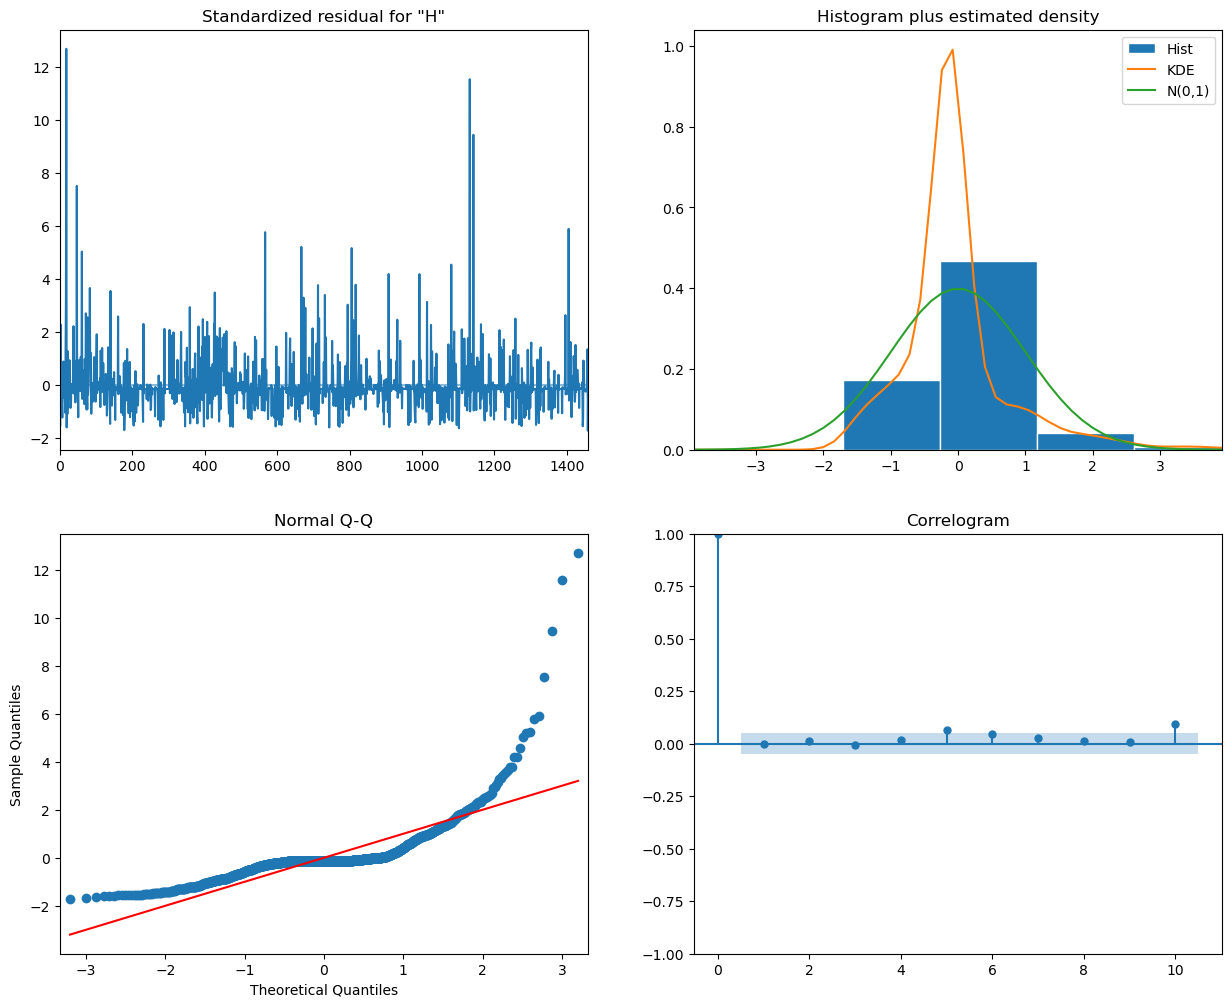

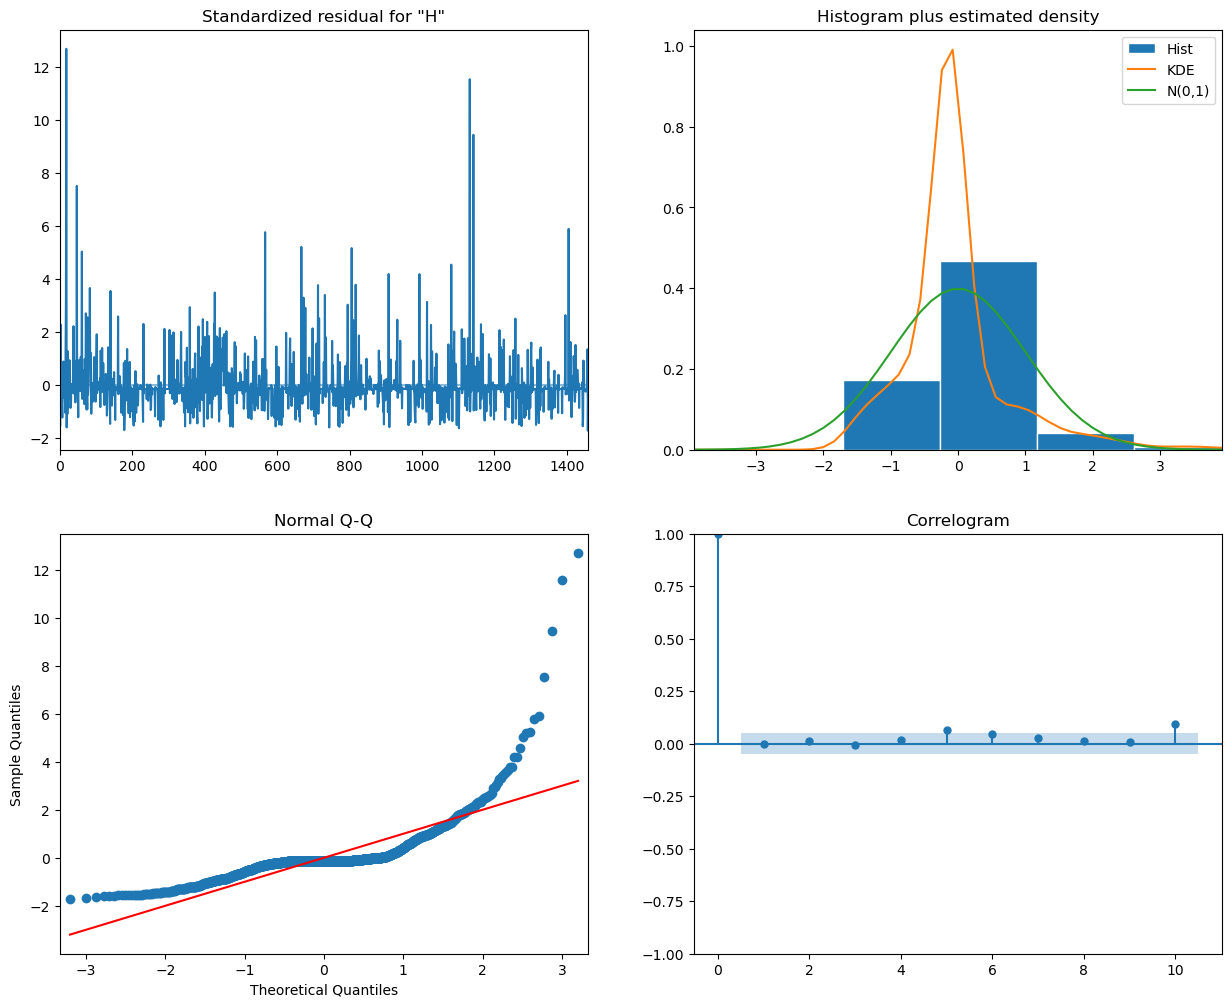

In [36]:
mtr_model = auto_arima(mtr_train['HCHO readings'], seasonal = True, trace = True, m = 12)
p,d,q = mtr_model.order
print(p,d,q)
mtr_arima = ARIMA(mtr_train['HCHO readings'], order=(p,d,q))
mtr_arima_fit = mtr_arima.fit()
print(mtr_arima_fit.summary())
mtr_arima_fit.plot_diagnostics(figsize=(15,12))

In [37]:
mtr_preds = mtr_arima_fit.forecast(steps = len(mtr_test))
mtr_mse = mean_squared_error(mtr_test['HCHO readings'], mtr_preds)
mtr_rmse = np.sqrt(mean_squared_error(mtr_test['HCHO readings'], mtr_preds))
mtr_r2 = r2_score(mtr_test['HCHO readings'], mtr_preds)

print(f'ARIMA RMSE for Matara: {mtr_mse}')
print(f'R-squared value for Matara: {mtr_rmse}')
print(f'ARIMA MSE for Matara: {mtr_r2}\n')
print(mtr_preds)

ARIMA RMSE for Matara: 2.963771747391791e-09
R-squared value for Matara: 5.4440534047635786e-05
ARIMA MSE for Matara: -0.00023335263170953802

1460    0.000101
1461    0.000101
1462    0.000101
1463    0.000101
1464    0.000101
          ...   
1821    0.000101
1822    0.000101
1823    0.000101
1824    0.000101
1825    0.000101
Name: predicted_mean, Length: 366, dtype: float64


In [38]:
forecast_range = 30
forecast_idx = pd.date_range(start = matara['Current date'].max(), periods = forecast_range+1, freq = 'D')[1:]
forecast_HCHO = cmb_arima_fit.forecast(steps = forecast_range)
mtr_forecast = pd.DataFrame({'Current date': forecast_idx, 'HCHO_value': forecast_HCHO, 'Location':'Matara'})
mtr_forecast.head()

,Current date,HCHO_value,Location
1460,2024-01-01,0.000206,Matara
1461,2024-01-02,0.000203,Matara
1462,2024-01-03,0.000197,Matara
1463,2024-01-04,0.000196,Matara
1464,2024-01-05,0.000196,Matara


In [39]:
mtr_forecast.to_csv('Forecast Data/matara_forecast.csv')

### Training for Jaffna

In [40]:
# Import dataset
jaffna = pd.read_csv('City Datasets/Jaffna Proper.csv')
jaffna.head()

,HCHO readings,Location,Current date,Next Date
0,0.000058,Jaffna Proper,2019-01-01,2019-01-02
1,0.000102,Jaffna Proper,2019-01-02,2019-01-03
2,0.000039,Jaffna Proper,2019-01-03,2019-01-04
3,0.000114,Jaffna Proper,2019-01-04,2019-01-05
4,0.000159,Jaffna Proper,2019-01-05,2019-01-06


In [41]:
dropped_columns = ['Location','Next Date']

jfn_dataset = jaffna.drop(columns = dropped_columns)
jfn_dataset = jfn_dataset.reset_index(drop = True)
jfn_dataset.head()

,HCHO readings,Current date
0,0.000058,2019-01-01
1,0.000102,2019-01-02
2,0.000039,2019-01-03
3,0.000114,2019-01-04
4,0.000159,2019-01-05


In [42]:
jaffna['Current date'] = pd.to_datetime(jaffna['Current date'])

In [43]:
jfn_split = int(len(jaffna) * 0.8)
jfn_train, jfn_test = jaffna.iloc[:jfn_split],jaffna.iloc[jfn_split:]

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=8.22 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-24128.536, Time=0.32 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-23536.136, Time=1.82 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-24156.182, Time=2.82 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-21998.398, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-24154.950, Time=1.36 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=4.89 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=-24154.410, Time=3.08 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=-23529.077, Time=5.04 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=19.81 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=-24129.564, Time=2.47 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-24168.193, Time=3.67 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-24167.351, Time=1.48 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=4.33 sec
 ARIMA(1,0,1)(0,0,

C:\Users\wickn\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:          HCHO readings   No. Observations:                 1460
Model:                 ARIMA(5, 0, 0)   Log Likelihood               12093.498
Date:                Sun, 21 Apr 2024   AIC                         -24172.997
Time:                        15:44:26   BIC                         -24135.994
Sample:                             0   HQIC                        -24159.193
                               - 1460                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001   2.87e-06     39.471      0.000       0.000       0.000
ar.L1          0.1506   5.26e-11   2.86e+09      0.000       0.151       0.151
ar.L2          0.0507   2.31e-11   2.19e+09      0.0

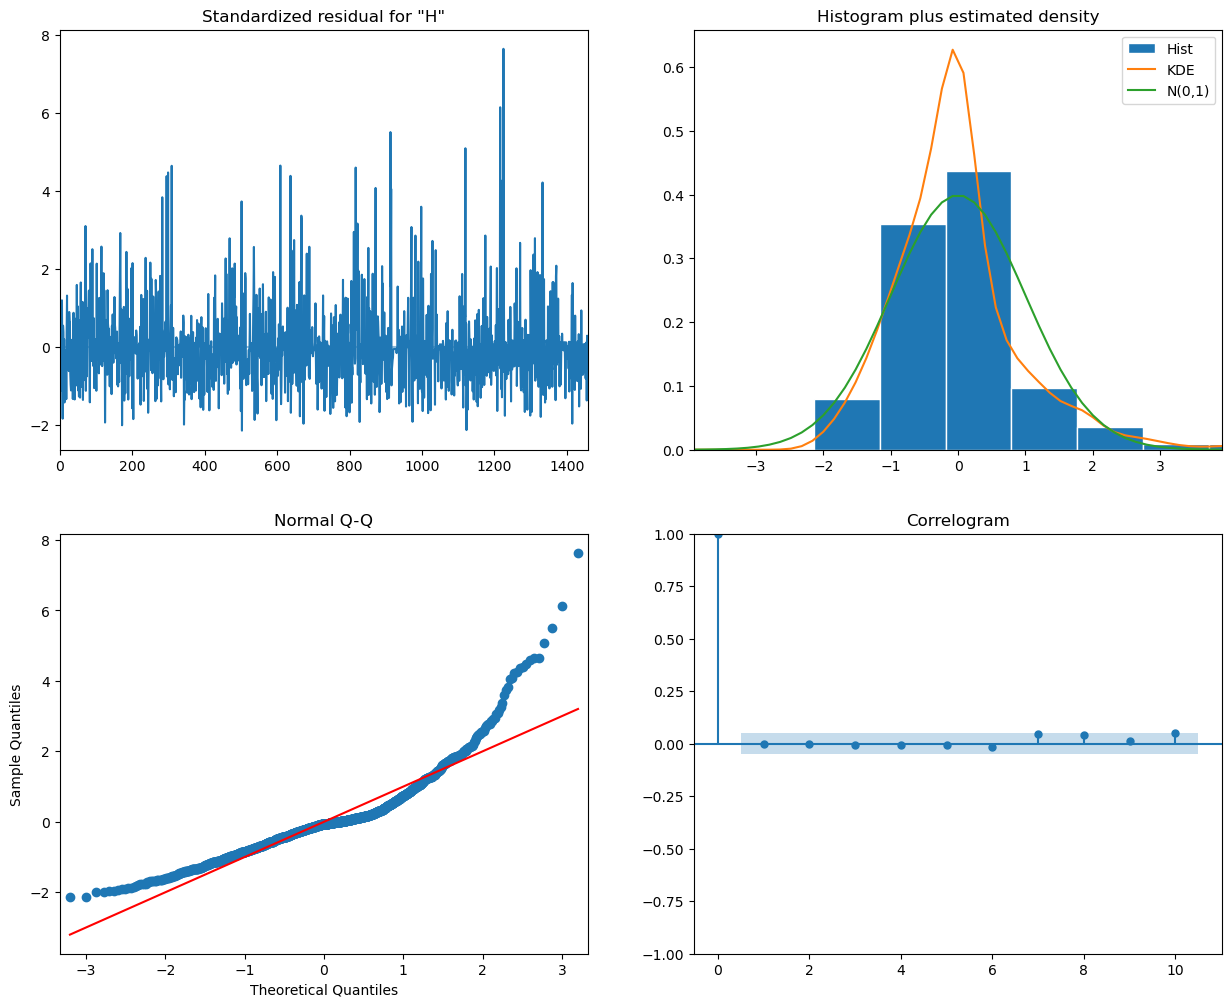

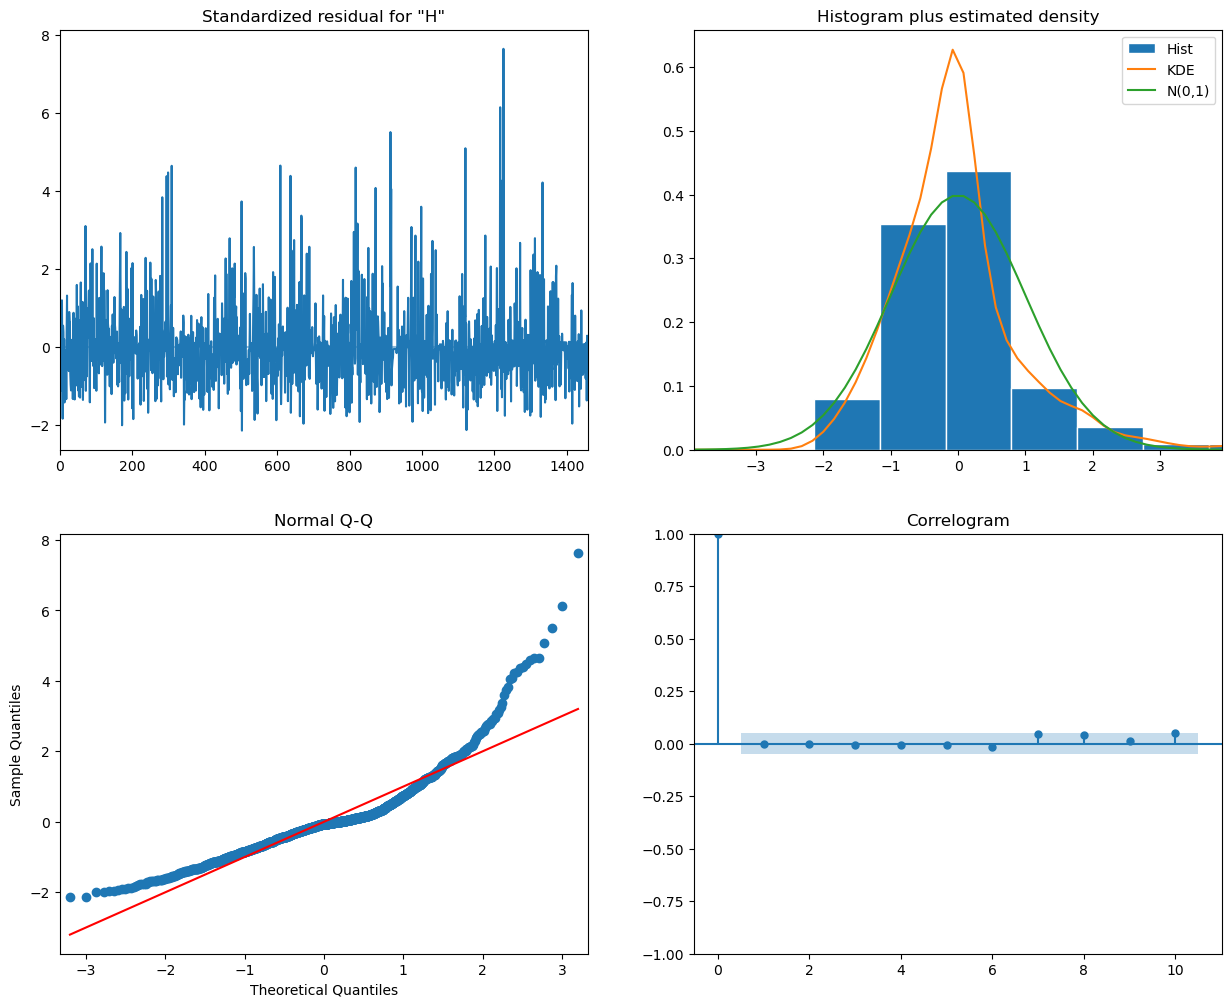

In [44]:
jfn_model = auto_arima(jfn_train['HCHO readings'], seasonal = True, trace = True, m = 12)
p,d,q = jfn_model.order
print(p,d,q)
jfn_arima = ARIMA(jfn_train['HCHO readings'], order=(p,d,q))
jfn_arima_fit = jfn_arima.fit()
print(jfn_arima_fit.summary())
jfn_arima_fit.plot_diagnostics(figsize=(15,12))

In [45]:
jfn_preds = cmb_arima_fit.forecast(steps = len(jfn_test))
jfn_mse = mean_squared_error(jfn_test['HCHO readings'], jfn_preds)
jfn_rmse = np.sqrt(mean_squared_error(jfn_test['HCHO readings'], jfn_preds))
jfn_r2 = r2_score(jfn_test['HCHO readings'], jfn_preds)

print(f'ARIMA RMSE for Jaffna: {jfn_mse}')
print(f'R-squared value for Jaffna: {jfn_rmse}')
print(f'ARIMA MSE for Jaffna: {jfn_r2}\n')
print(jfn_preds)

ARIMA RMSE for Jaffna: 1.0362472736586611e-08
R-squared value for Jaffna: 0.00010179623144589691
ARIMA MSE for Jaffna: -1.5241525361476516

1460    0.000206
1461    0.000203
1462    0.000197
1463    0.000196
1464    0.000196
          ...   
1821    0.000196
1822    0.000196
1823    0.000196
1824    0.000196
1825    0.000196
Name: predicted_mean, Length: 366, dtype: float64


In [46]:
forecast_range = 30
forecast_idx = pd.date_range(start = jaffna['Current date'].max(), periods = forecast_range+1, freq = 'D')[1:]
forecast_HCHO = jfn_arima_fit.forecast(steps = forecast_range)
jfn_forecast = pd.DataFrame({'Current date': forecast_idx, 'HCHO_value': forecast_HCHO, 'Location':'Jaffna'})
jfn_forecast.head()

,Current date,HCHO_value,Location
1460,2024-01-01,0.000108,Jaffna
1461,2024-01-02,0.000111,Jaffna
1462,2024-01-03,0.000111,Jaffna
1463,2024-01-04,0.000113,Jaffna
1464,2024-01-05,0.000113,Jaffna


In [47]:
jfn_forecast.to_csv('Forecast Data/jaffna_forecast.csv')

### Training for Kandy

In [48]:
# Import dataset
kandy = pd.read_csv('City Datasets/Kandy Proper.csv')
kandy.head()

,HCHO readings,Location,Current date,Next Date
0,0.000176,Kandy Proper,2019-01-01,2019-01-02
1,0.000092,Kandy Proper,2019-01-02,2019-01-03
2,0.000106,Kandy Proper,2019-01-03,2019-01-04
3,0.000191,Kandy Proper,2019-01-04,2019-01-05
4,0.000122,Kandy Proper,2019-01-05,2019-01-06


In [49]:
dropped_columns = ['Location','Next Date']

knd_dataset = kandy.drop(columns = dropped_columns)
knd_dataset = knd_dataset.reset_index(drop = True)
knd_dataset.head()

,HCHO readings,Current date
0,0.000176,2019-01-01
1,0.000092,2019-01-02
2,0.000106,2019-01-03
3,0.000191,2019-01-04
4,0.000122,2019-01-05


In [50]:
kandy['Current date'] = pd.to_datetime(kandy['Current date'])

In [51]:
knd_split = int(len(kandy) * 0.8)
knd_train, knd_test = kandy.iloc[:knd_split],kandy.iloc[knd_split:]

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-23634.541, Time=5.36 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-23654.459, Time=0.40 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-24066.068, Time=3.83 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-24368.142, Time=0.94 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-23656.445, Time=0.29 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=-24371.625, Time=0.94 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-24369.813, Time=1.43 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=-24366.132, Time=1.59 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-24357.752, Time=0.84 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=-24399.611, Time=0.88 sec
 ARIMA(0,1,2)(1,0,0)[12] intercept   : AIC=-24397.547, Time=1.44 sec
 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=-24395.297, Time=1.39 sec
 ARIMA(0,1,2)(1,0,1)[12] intercept   : AIC=-24393.283, Time=1.55 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=-23639.764, Time=

C:\Users\wickn\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:          HCHO readings   No. Observations:                 1460
Model:                 ARIMA(0, 1, 5)   Log Likelihood               12186.658
Date:                Sun, 21 Apr 2024   AIC                         -24361.317
Time:                        15:45:24   BIC                         -24329.603
Sample:                             0   HQIC                        -24349.486
                               - 1460                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8232   1.22e-19  -6.74e+18      0.000      -0.823      -0.823
ma.L2          0.0076   9.96e-20   7.61e+16      0.000       0.008       0.008
ma.L3         -0.0079   9.07e-20  -8.74e+16      0.0

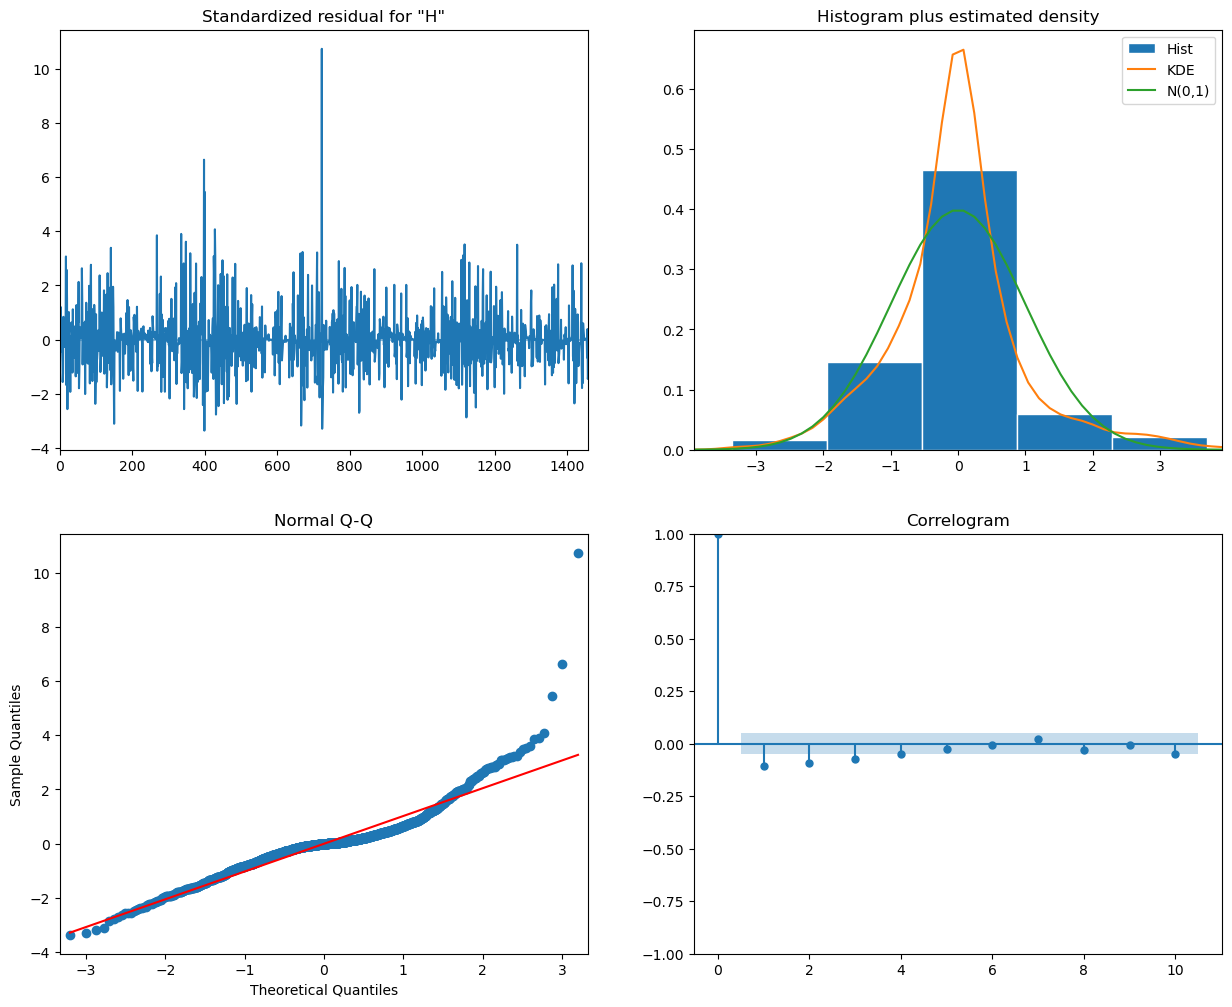

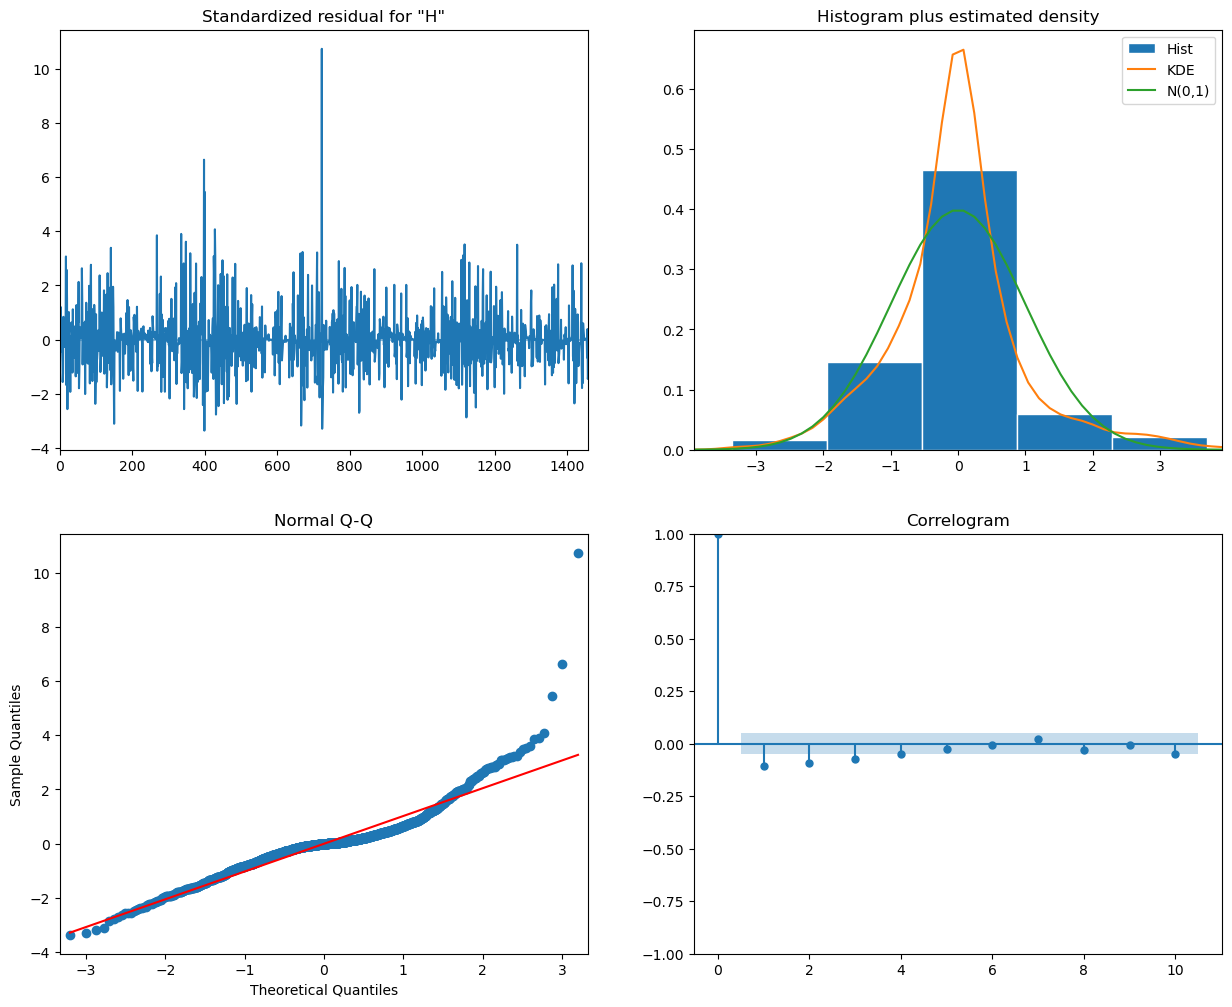

In [52]:
knd_model = auto_arima(knd_train['HCHO readings'], seasonal = True, trace = True, m = 12)
p,d,q = knd_model.order
print(p,d,q)
knd_arima = ARIMA(knd_train['HCHO readings'], order=(p,d,q))
knd_arima_fit = knd_arima.fit()
print(knd_arima_fit.summary())
knd_arima_fit.plot_diagnostics(figsize=(15,12))

In [53]:
knd_preds = knd_arima_fit.forecast(steps = len(knd_test))
knd_mse = mean_squared_error(knd_test['HCHO readings'], knd_preds)
knd_rmse = np.sqrt(mean_squared_error(knd_test['HCHO readings'], knd_preds))
knd_r2 = r2_score(knd_test['HCHO readings'], knd_preds)

print(f'ARIMA RMSE for Kandy: {knd_mse}')
print(f'R-squared value for Kandy: {knd_rmse}')
print(f'ARIMA MSE for Kandy: {knd_r2}\n')
print(knd_preds)

ARIMA RMSE for Kandy: 5.350142130586924e-09
R-squared value for Kandy: 7.314466576987637e-05
ARIMA MSE for Kandy: -1.1701843269855612

1460    0.000053
1461    0.000050
1462    0.000053
1463    0.000059
1464    0.000062
          ...   
1821    0.000062
1822    0.000062
1823    0.000062
1824    0.000062
1825    0.000062
Name: predicted_mean, Length: 366, dtype: float64


In [54]:
forecast_range = 30
forecast_idx = pd.date_range(start = kandy['Current date'].max(), periods = forecast_range+1, freq = 'D')[1:]
forecast_HCHO = knd_arima_fit.forecast(steps = forecast_range)
knd_forecast = pd.DataFrame({'Current date': forecast_idx, 'HCHO_value': forecast_HCHO, 'Location':'Kandy'})
knd_forecast.head()

,Current date,HCHO_value,Location
1460,2024-01-01,0.000053,Kandy
1461,2024-01-02,0.000050,Kandy
1462,2024-01-03,0.000053,Kandy
1463,2024-01-04,0.000059,Kandy
1464,2024-01-05,0.000062,Kandy


In [55]:
knd_forecast.to_csv('Forecast Data/kandy_forecast.csv')

### Training for Kurunegala

In [56]:
# Import dataset
kurunegala = pd.read_csv('City Datasets/Kurunegala Proper.csv')
kurunegala.head()

,HCHO readings,Location,Current date,Next Date
0,0.000088,Kurunegala Proper,2019-01-01,2019-01-02
1,0.000137,Kurunegala Proper,2019-01-02,2019-01-03
2,0.000148,Kurunegala Proper,2019-01-03,2019-01-04
3,0.000140,Kurunegala Proper,2019-01-04,2019-01-05
4,0.000249,Kurunegala Proper,2019-01-05,2019-01-06


In [57]:
dropped_columns = ['Location','Next Date']

krn_dataset = kurunegala.drop(columns = dropped_columns)
krn_dataset = krn_dataset.reset_index(drop = True)
krn_dataset.head()

,HCHO readings,Current date
0,0.000088,2019-01-01
1,0.000137,2019-01-02
2,0.000148,2019-01-03
3,0.000140,2019-01-04
4,0.000249,2019-01-05


In [58]:
kurunegala['Current date'] = pd.to_datetime(kurunegala['Current date'])

In [59]:
krn_split = int(len(kurunegala) * 0.8)
krn_train, krn_test = kurunegala.iloc[:krn_split],kurunegala.iloc[krn_split:]

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-24198.083, Time=2.05 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-23457.582, Time=0.42 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-23766.396, Time=2.67 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-24097.670, Time=8.69 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-23459.432, Time=0.24 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-24200.988, Time=2.25 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-24199.840, Time=1.36 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=-24205.432, Time=4.53 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=-24203.802, Time=4.61 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=-24196.456, Time=3.94 sec
 ARIMA(2,1,1)(0,0,2)[12] intercept   : AIC=-24149.909, Time=56.69 sec
 ARIMA(3,1,2)(0,0,2)[12] intercept   : AIC=-24181.783, Time=39.82 sec
 ARIMA(2,1,3)(0,0,2)[12] intercept   : AIC=-24211.258, Time=17.61 sec
 ARIMA(2,1,3)(0,0,1)[12] intercept   : AIC=-24206.414, Ti

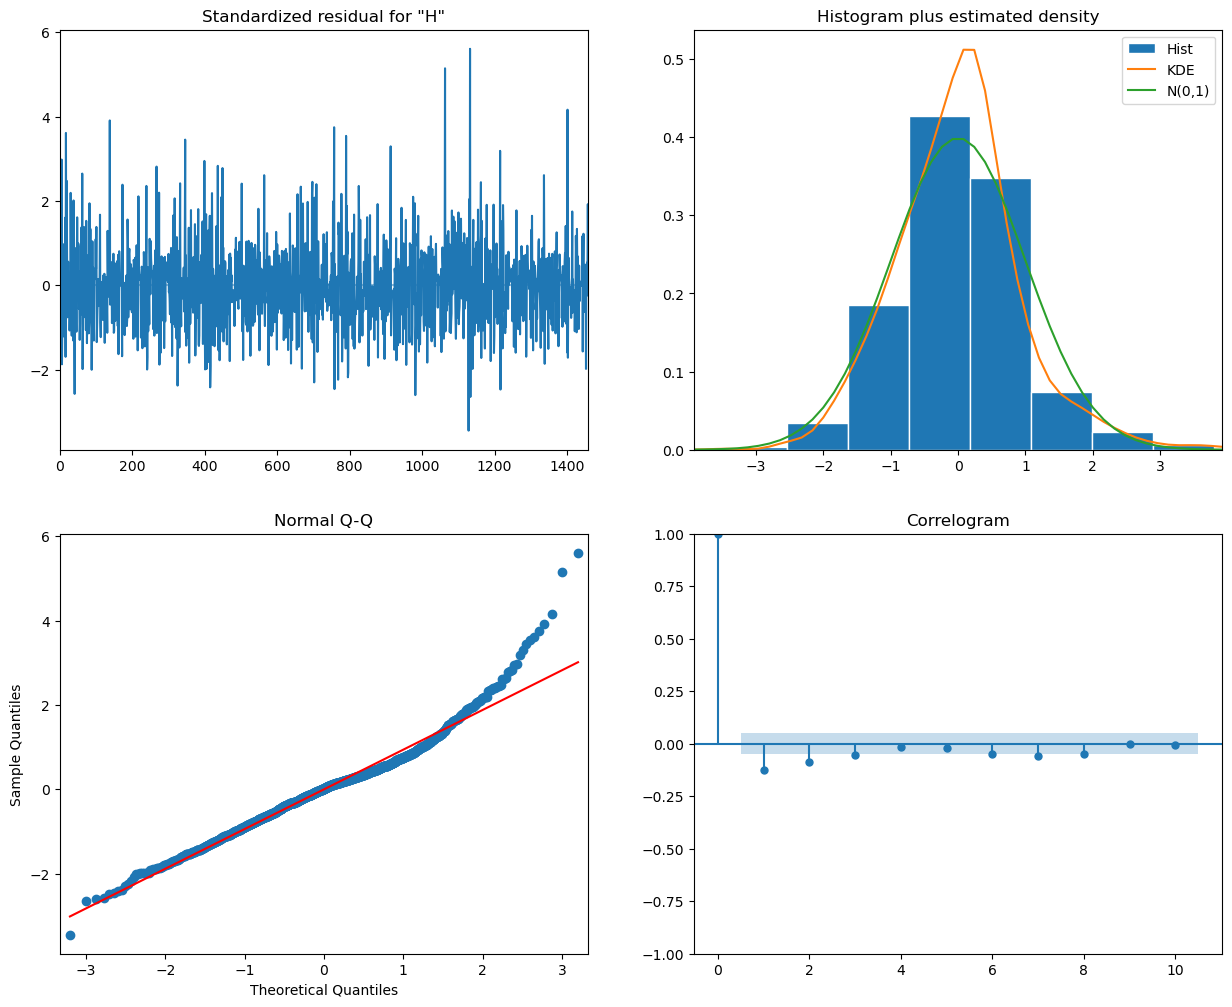

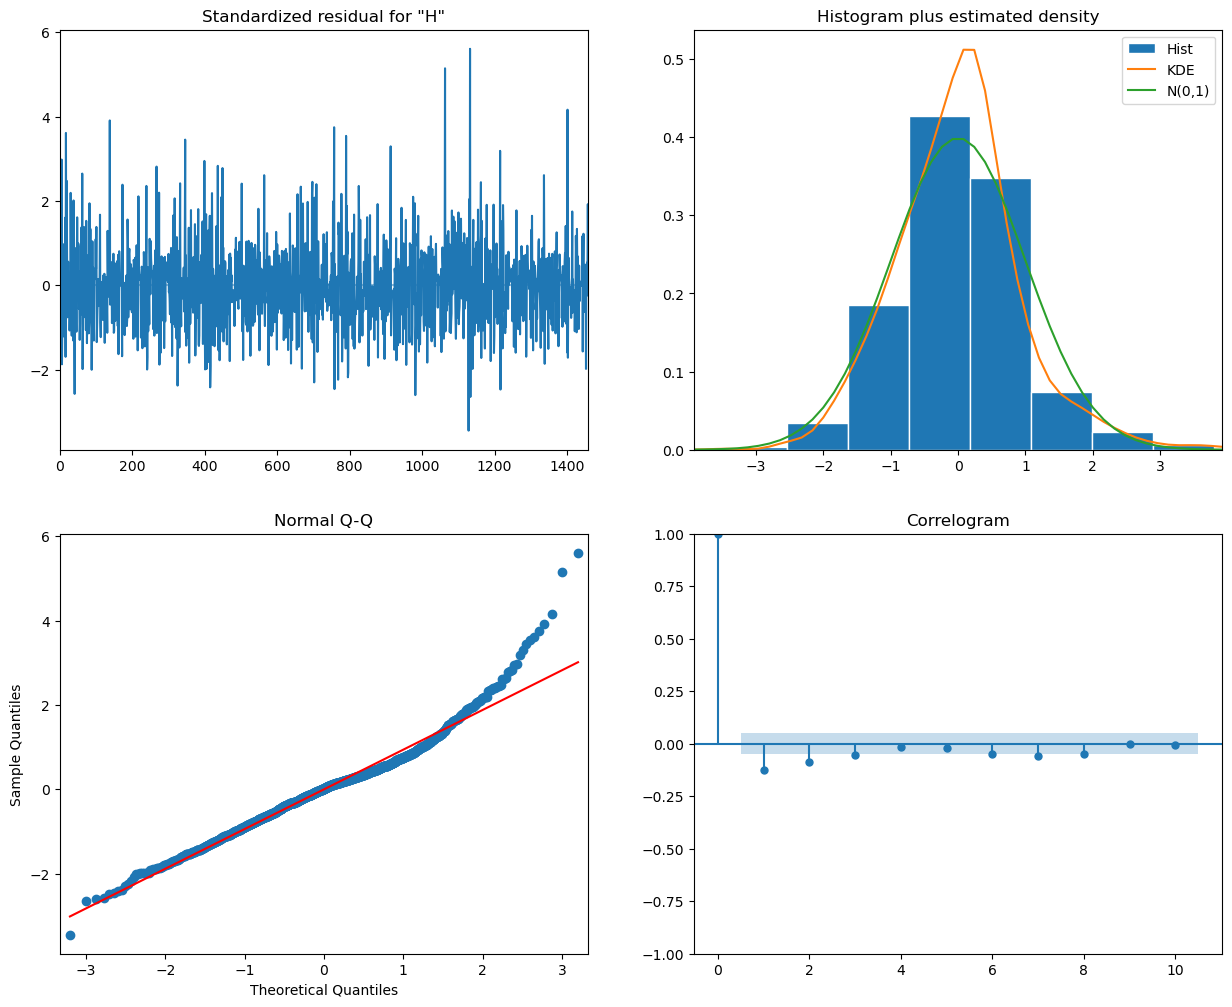

In [60]:
krn_model = auto_arima(krn_train['HCHO readings'], seasonal = True, trace = True, m = 12)
p,d,q = krn_model.order
print(p,d,q)
krn_arima = ARIMA(cmb_train['HCHO readings'], order=(p,d,q))
krn_arima_fit = krn_arima.fit()
print(krn_arima_fit.summary())
krn_arima_fit.plot_diagnostics(figsize=(15,12))

In [61]:
krn_preds = krn_arima_fit.forecast(steps = len(krn_test))
krn_mse = mean_squared_error(krn_test['HCHO readings'], krn_preds)
krn_rmse = np.sqrt(mean_squared_error(krn_test['HCHO readings'], krn_preds))
krn_r2 = r2_score(krn_test['HCHO readings'], krn_preds)

print(f'ARIMA RMSE for Kurunegala: {krn_mse}')
print(f'R-squared value for Kurunegala: {krn_rmse}')
print(f'ARIMA MSE for Kurunegala: {krn_r2}\n')
print(krn_preds)

ARIMA RMSE for Kurunegala: 7.19645972952152e-09
R-squared value for Kurunegala: 8.483194993350984e-05
ARIMA MSE for Kurunegala: -0.891657158427867

1460    0.000206
1461    0.000203
1462    0.000197
1463    0.000196
1464    0.000196
          ...   
1821    0.000196
1822    0.000196
1823    0.000196
1824    0.000196
1825    0.000196
Name: predicted_mean, Length: 366, dtype: float64


In [62]:
forecast_range = 30
forecast_idx = pd.date_range(start = kandy['Current date'].max(), periods = forecast_range+1, freq = 'D')[1:]
forecast_HCHO = krn_arima_fit.forecast(steps = forecast_range)
krn_forecast = pd.DataFrame({'Current date': forecast_idx, 'HCHO_value': forecast_HCHO, 'Location':'Kurunegala'})
krn_forecast.head()

,Current date,HCHO_value,Location
1460,2024-01-01,0.000206,Kurunegala
1461,2024-01-02,0.000203,Kurunegala
1462,2024-01-03,0.000197,Kurunegala
1463,2024-01-04,0.000196,Kurunegala
1464,2024-01-05,0.000196,Kurunegala


In [63]:
krn_forecast.to_csv('Forecast Data/kurunegala_forecast.csv')